**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# ****Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [88]:
# Import helpful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_breast_cancer
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
import warnings
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

# Load the data, and separate the target
train_data_path = '../input/train.csv'
train_data = pd.read_csv(train_data_path)
train_data = train_data.dropna(subset=['SalePrice'])
train_data.reset_index(drop=True, inplace=True)
train_data = train_data.drop(columns=['Id'])
y_train = pd.DataFrame(train_data.SalePrice)
X_train = train_data.drop('SalePrice', axis=1)

# path to file you will use for predictions
test_data_path = '../input/test.csv'
test_data = pd.read_csv(test_data_path)
test_data.reset_index(drop=True, inplace=True)
test_data = test_data.drop(columns=['Id'])

## Target

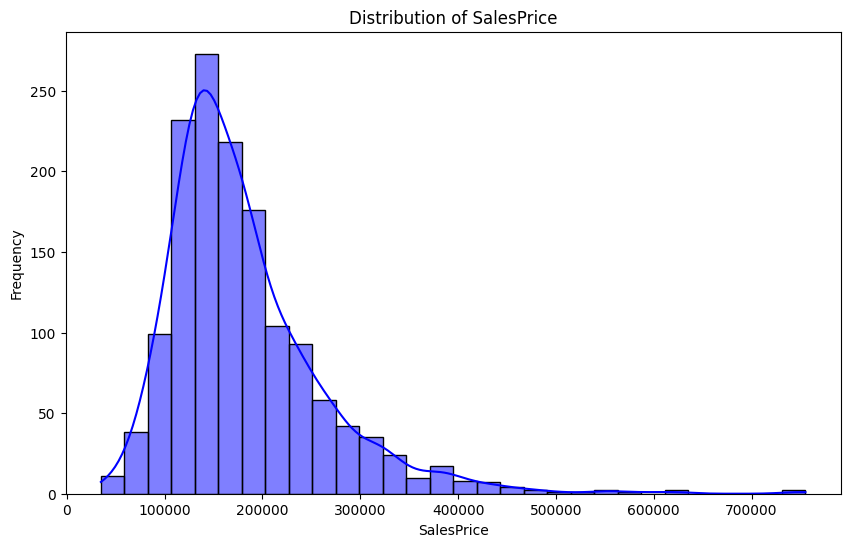

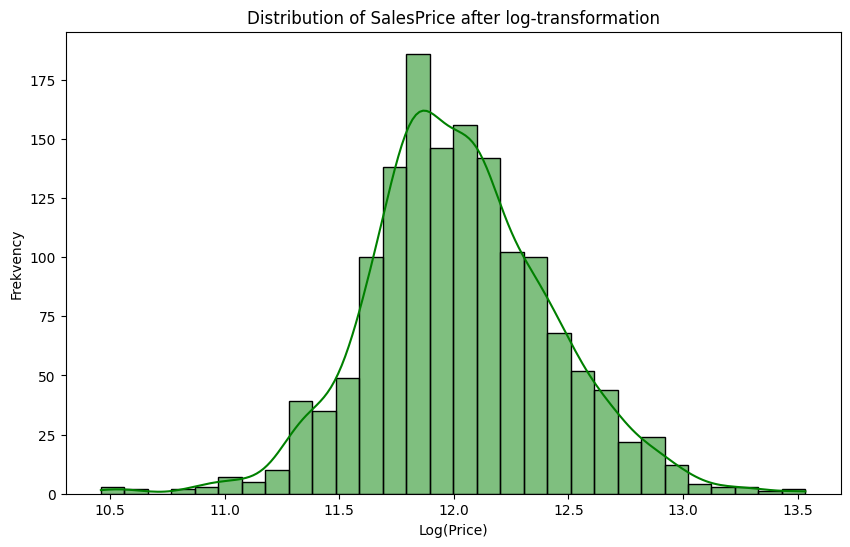

In [89]:
# First plot: Distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(y_train['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Distribution of SalesPrice')
plt.xlabel('SalesPrice')
plt.ylabel('Frequency')
plt.show()

# Log transform the prices
y_transformed = np.log(y_train['SalePrice'] + 1) # Add 1 to avoid log(0)

# Second plot: Distribution of log-transformed SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(y_transformed, kde=True, bins=30, color='green')
plt.title('Distribution of SalesPrice after log-transformation')
plt.xlabel('Log(Price)')
plt.ylabel('Frekvency')
plt.show()

In [90]:
# Get column types
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
Categorical columns: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'

In [91]:
#Missing Values in these columns means that there is no available, not missing value --> replace NaN value by 'NA'

cat_cols_missing_by_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
train_data[cat_cols_missing_by_NA] = train_data[cat_cols_missing_by_NA].fillna('NA')
test_data[cat_cols_missing_by_NA] = test_data[cat_cols_missing_by_NA].fillna('NA')


In [92]:
# Identify columns with high missing values ratio and drop it from train_data

cat_cols_high_missing_ratio = []
for col in train_data.columns:
    # If it contains a lot of missing values, we recommend dropping it
    missing_ratio = train_data[col].isnull().mean()
    if missing_ratio > 0.4:
        cat_cols_high_missing_ratio.append(col)

print(f"Columns that contains more than 40% missing values:", cat_cols_high_missing_ratio)

for column in cat_cols_high_missing_ratio:
    train_data.drop(columns=[column], inplace=True)

# Update numerical and categorical column lists
numerical_cols = [col for col in numerical_cols if col not in cat_cols_high_missing_ratio]
categorical_cols = [col for col in categorical_cols if col not in cat_cols_high_missing_ratio]

Columns that contains more than 40% missing values: ['MasVnrType']


## ADD NEW CATEGORICAL COLUMNS

In [93]:
# Defining new combined columns and their calculations
new_columns = {
    'TotalSF': lambda df: df['TotalBsmtSF'] + df['GrLivArea'],
    'TotalFlrSF': lambda df: df['1stFlrSF'] + df['2ndFlrSF'],
    'TotalPorchSF': lambda df: df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'],
    'TotalBathrooms': lambda df: df['FullBath'] + df['BsmtFullBath'] + 0.5 * (df['HalfBath'] + df['BsmtHalfBath'])
}

# Defining binary columns (boolean flags)
binary_columns = {
    'HasBasement': 'TotalBsmtSF',
    'HasGarage': 'GarageArea',
    'HasPorch': 'TotalPorchSF',
    'HasPool': 'PoolArea'
}

# Function to add new combined columns
def add_combined_columns(data, columns):
    for new_col, formula in columns.items():
        data[new_col] = formula(data)

# Function to add binary columns
def add_binary_columns(data, columns):
    for new_col, base_col in columns.items():
        data[new_col] = (data[base_col] > 0).astype(int)

# Apply to training and testing datasets
add_combined_columns(train_data, new_columns)
add_combined_columns(test_data, new_columns)

add_binary_columns(train_data, binary_columns)
add_binary_columns(test_data, binary_columns)

# Update the list of categorical columns
categorical_cols = list(categorical_cols)
categorical_cols.extend(binary_columns.keys())

# Update the list of categorical columns
categorical_cols = list(categorical_cols)
categorical_cols.extend(binary_columns.keys())

# Update the list of numerical columns
numerical_cols = list(numerical_cols) + ['TotalSF', 'TotalFlrSF', 'TotalPorchSF', 'TotalBathrooms']

# CATEGORICAL COLUMNS

## Show distribution of values

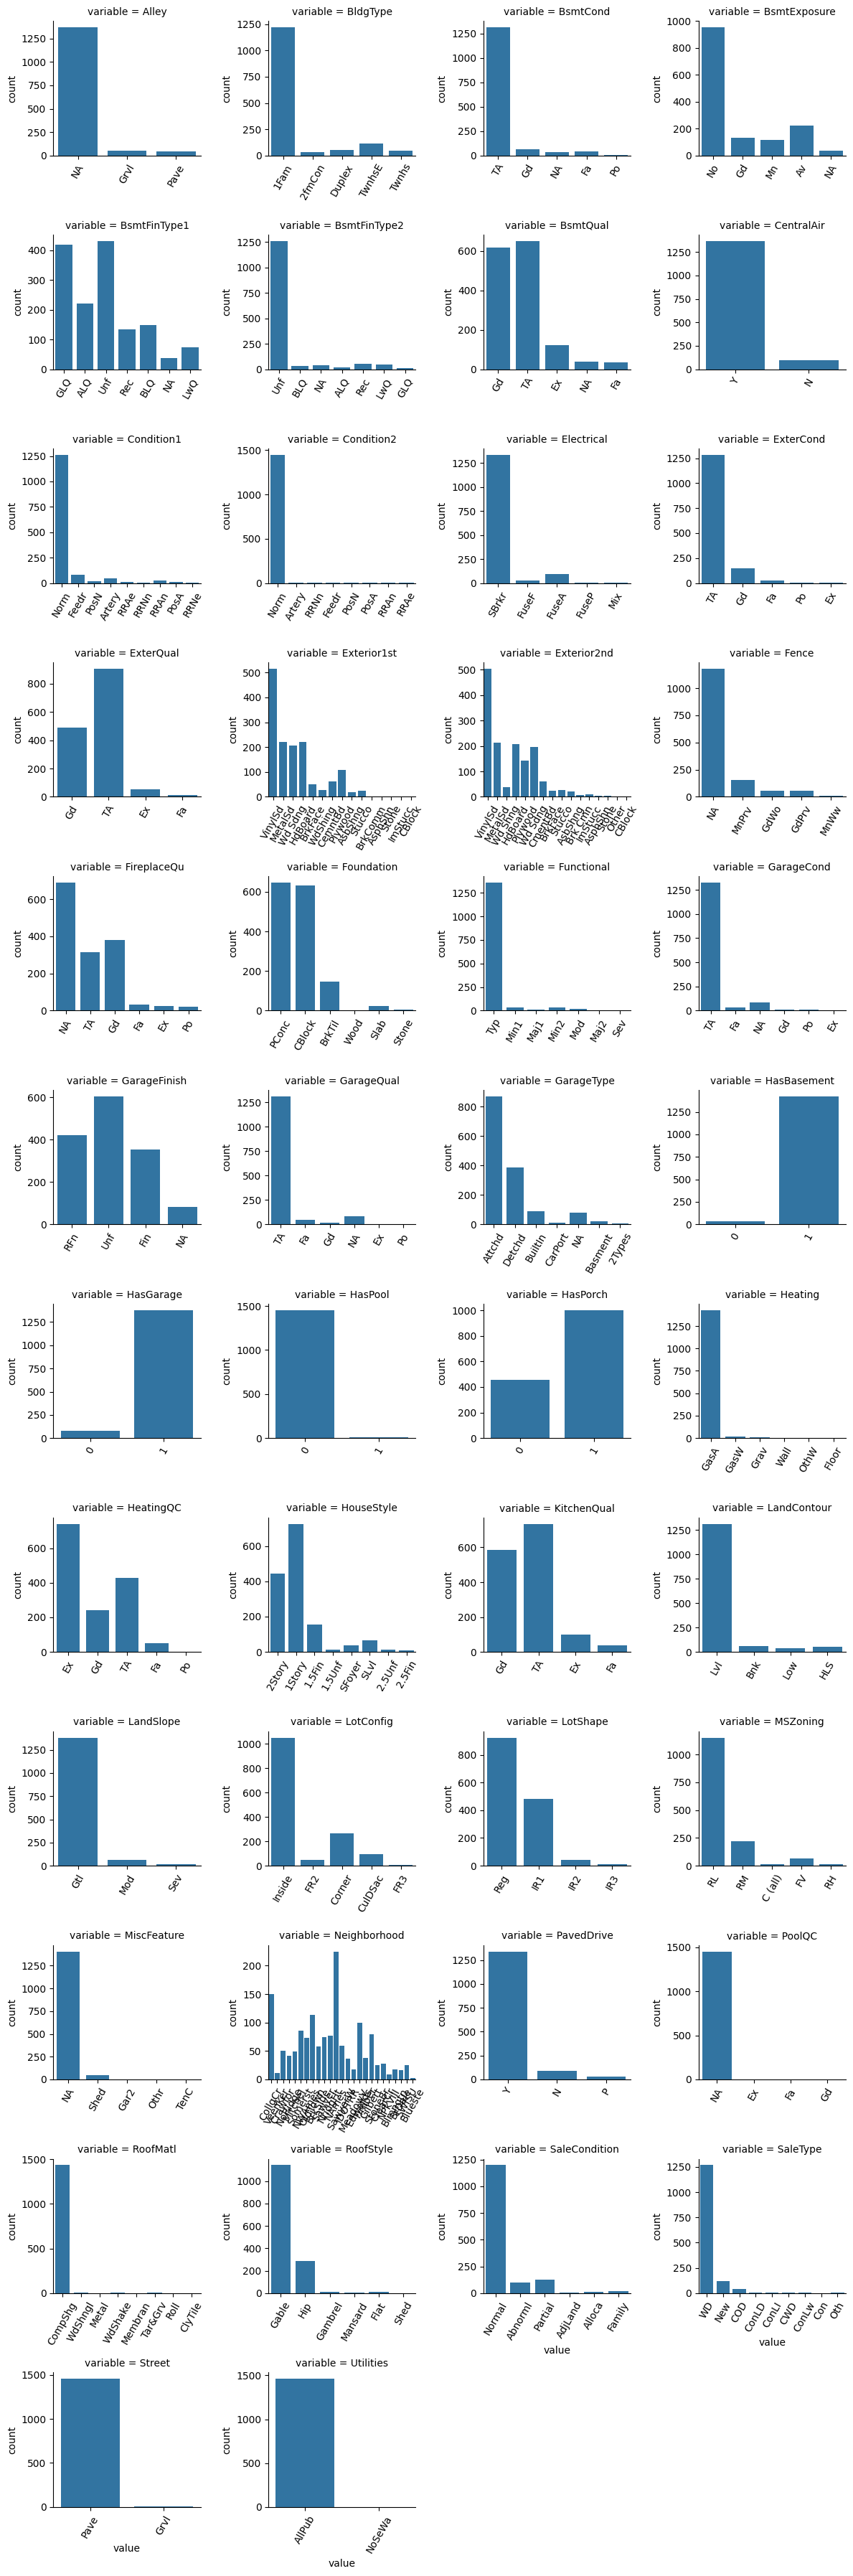

In [94]:
# Count plots of categorical features
f = pd.melt(train_data, value_vars=sorted(categorical_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

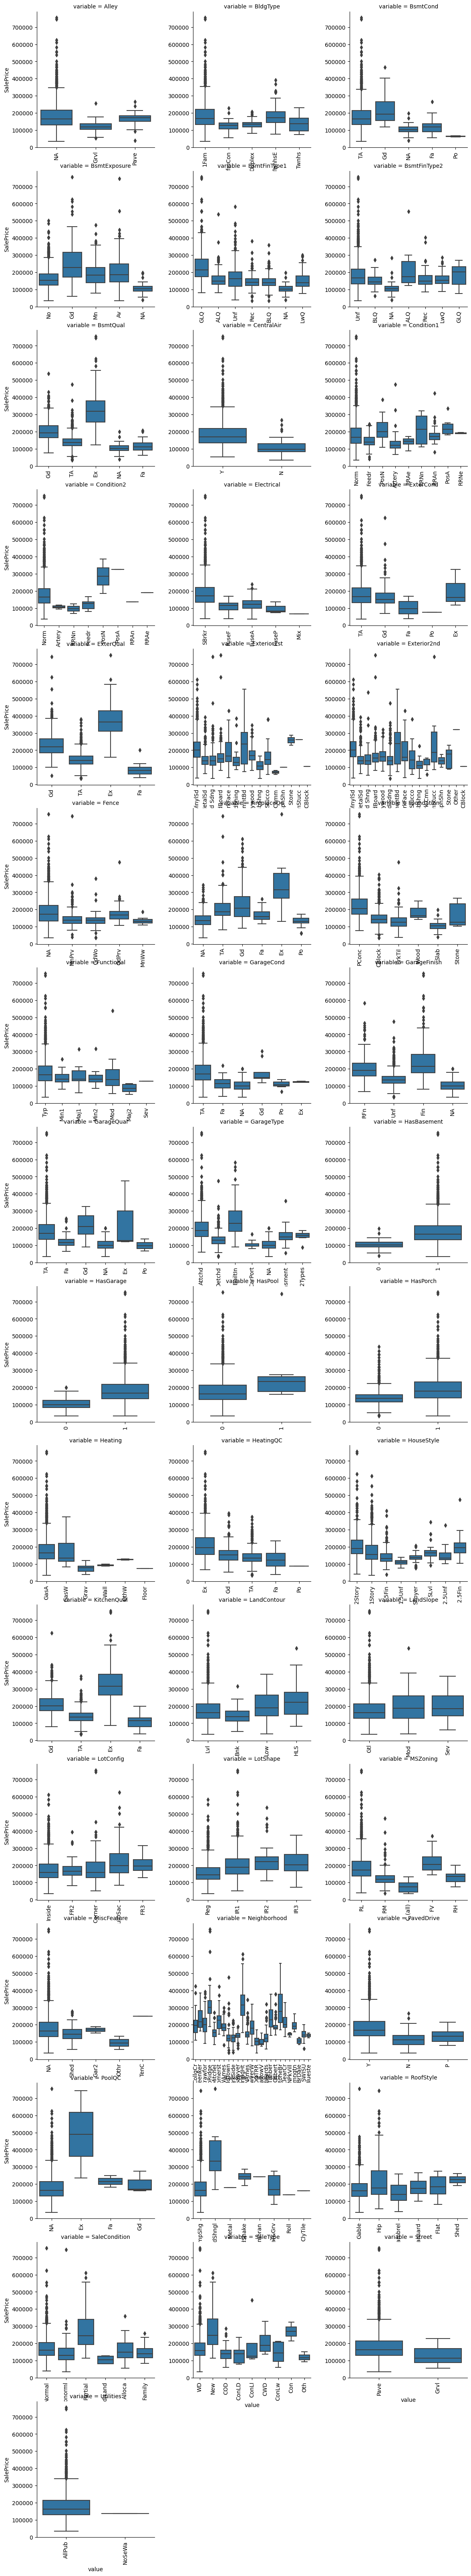

In [95]:
# Assuming train_data and categorical_cols are already defined
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=sorted(categorical_cols))

# Fix: Use 'height' instead of 'size'
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')

# Rotate the x-tick labels
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

plt.show()

## DROP IRRELEVANT COLUMNS

### CHECK IF CATEGORICAL COLUMNS UNIQUE VALUES ARE IN TEST DATA

In [96]:
# Check if all unique values in categorical columns in test_data are also in train_data
# (if any values are missing, the corresponding columns will be dropped)

columns_to_check = categorical_cols.copy()
columns_missing_values = []

# Compare unique values for each column
for col in columns_to_check:
    unique_train = set(train_data[col].dropna().unique())  # Unique values in train_data (excluding NaN)
    unique_test = set(test_data[col].dropna().unique())  # Unique values in test_data (excluding NaN)
    
    if not unique_test.issubset(unique_train):  # If test_data has values missing in train_data
        columns_missing_values.append(col)

# Print columns that do not meet the condition
print(f"Columns in train_data that do not contain all unique values from test_data:", columns_missing_values)

Columns in train_data that do not contain all unique values from test_data: []


### CHECK IF ANY CATEGORICAL COLUMN DOES NOT CONTAIN LESS THAN 2 UNIQUE VALUES

In [97]:
# Identify columns with less than 2 unique values

cat_cols_few_unique_values = []
for col in categorical_cols:
    unique_values = train_data[col].nunique()
        
    # Check the number of unique values
    if unique_values < 2:
        cat_cols_few_unique_values.append(col)

print(f"Columns that contains less than 2 unique not NaN values:", cat_cols_few_unique_values)

Columns that contains less than 2 unique not NaN values: []


### CHECK SIGNIFICATION OF CATEGORICAL COLUMNS FOR SALEPRICE

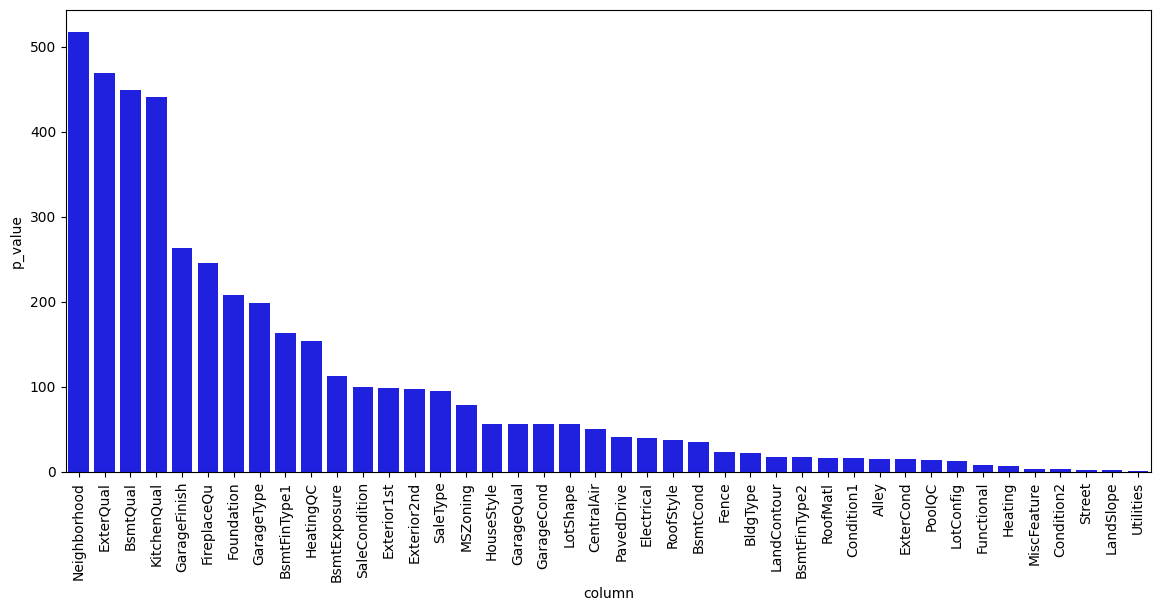

Columns without significant relation: ['Street', 'LandSlope', 'Utilities']


In [98]:
# Target variable
target_column = 'SalePrice'  # Change this to the name of your target column

# Work with categorical columns
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

# Output dataframe for decision-making
evaluation_results = []

# Testing categorical columns
for col in categorical_cols:

    # Replace missing values
    train_data[col] = train_data[col].fillna('Missing')

    # For categorical vs numerical target: ANOVA
    if train_data[target_column].dtype in ['float64', 'int64']:

        groups = [train_data[target_column][train_data[col] == val] for val in train_data[col].unique()]
        f_stat, p_value = f_oneway(*groups)
        
        if p_value < 0.05:  # Significant relationship with the target variable
            evaluation_results.append({'column': col, 'reason': 'significant relation (ANOVA)', 'f_stat': f_stat, 'p_value': p_value})
        else:
            evaluation_results.append({'column': col, 'reason': 'no significant relation (ANOVA)', 'f_stat': f_stat, 'p_value': p_value})
    

train_data = train_data.replace('Missing', np.nan)

# Results as a dataframe
results_df = pd.DataFrame(evaluation_results)


results_df.sort_values('p_value', inplace=True)
results_df.reset_index(drop=True, inplace=True)
# Assuming 'results_df' is your DataFrame
plt.figure(figsize=(14,6))

# Fix: Use keyword arguments to specify x and y
sns.barplot(x=results_df['column'], y=np.log(1. / results_df['p_value']), color='blue')

# Rotate the x-tick labels if necessary
plt.xticks(rotation=90)

# Display the plot
plt.show()

cat_cols_no_significant_relation = results_df[results_df['reason'] == 'no significant relation (ANOVA)']['column'].unique().tolist()
# Display decisions
print(f"Columns without significant relation:", cat_cols_no_significant_relation)

In [99]:
threshold = 0.95  # Set the threshold for dominance (e.g., 95%)

cat_cols_high_dominance = []
# Identify columns where one value dominates
for col in train_data.columns:
    dominant_ratio = train_data[col].value_counts(normalize=True).max()
    if dominant_ratio > threshold and col not in cat_cols_high_dominance:
        cat_cols_high_dominance.append(col)

# Display the results
print(f"Columns that have value with dominance more that 95%:", cat_cols_high_dominance)

Columns that have value with dominance more that 95%: ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal', 'HasBasement', 'HasPool']


In [100]:
categorical_cols = [
    col for col in categorical_cols
    if col not in cat_cols_few_unique_values
    and col not in cat_cols_high_dominance
    and col not in cat_cols_no_significant_relation
]

numerical_cols = [
    col for col in numerical_cols
    if col not in cat_cols_few_unique_values
    and col not in cat_cols_high_dominance
    and col not in cat_cols_no_significant_relation
]
# Display the updated list of categorical columns
print("Updated categorical columns:", categorical_cols)
# Display the updated list of numerical columns
print("Updated categorical columns:", numerical_cols)

# drop_cols
categorical_cols_drop = cat_cols_few_unique_values + cat_cols_no_significant_relation + cat_cols_high_dominance
train_data.drop(columns=categorical_cols_drop, inplace=True)


Updated categorical columns: ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
Updated categorical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold', 'YrSold', 'TotalSF', 'TotalFlrSF', 'TotalPorchSF', 

## ORDINAL ENCODING 

In [101]:
# Dictionary to define all categorical feature mappings for ordinal encoding
replacement_dicts = {
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},     # Excellent, Good, etc.
    'CentralAir': {'Y': 1, 'N': 0},  # Yes, No
    'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},  # Paved, Partial, Dirt/Gravel
    'BsmtExposure': {'Gd': 5, 'Av': 4, 'Mn': 3, 'No': 2, 'NA': 0},  # Good, Average, etc.
    'BsmtFinType1': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 0, 'Unf': 0, 'NA': 0},
    'BsmtFinType2': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 0, 'Unf': 0, 'NA': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},  # Finished, Refined, Unfinished
    'Alley': {'Pave': 2, 'Grvl': 1, 'NA': 0},  # Paved, Gravel, No Alley
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},  # Regular, Irregular
    'LandContour': {'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low': 1},  # Level, Banked, Hillside, Low
    'Utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},  # AllPublic, NoSewer, etc.
    'LandSlope': {'Gtl': 3, 'Mod': 2, 'Sev': 1},  # Gentle, Moderate, Severe Slope
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},  # Functionality types
}

# Function to apply replacement to the specified columns of the data
def apply_replacement(data, columns, replacement_dicts):
    """
    Apply replacements to the columns based on the provided dictionary mappings.
    """
    for col in columns:
        if col in replacement_dicts:
            data[col] = data[col].replace(replacement_dicts[col])
    return data

# List of categorical columns to be encoded (if not all columns are required, customize this list)
categorical_cols_for_OrdinalEncoding = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'CentralAir', 'PavedDrive',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'Alley', 'LotShape',
    'LandContour', 'Utilities', 'LandSlope', 'Functional'
]

categorical_cols_for_OrdinalEncoding = [col for col in categorical_cols_for_OrdinalEncoding if col not in categorical_cols_drop]

# Apply the replacements for both train and test datasets
train_data = apply_replacement(train_data, categorical_cols_for_OrdinalEncoding, replacement_dicts)
test_data = apply_replacement(test_data, categorical_cols_for_OrdinalEncoding, replacement_dicts)


## ONE HOT ENCODING

In [102]:
# List of columns for One-Hot Encoding
categorical_cols_for_OHEncoding = ['MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 
                                   'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Electrical', 'GarageType', 
                                   'Fence', 'SaleType', 'SaleCondition']
categorical_cols_for_OHEncoding = [col for col in categorical_cols_for_OHEncoding if col not in categorical_cols_drop]
# One-Hot Encoding
onehot_encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

# Transforming the training and test data using the same encoder
onehot_encoded_train_data = onehot_encoder.fit_transform(train_data[categorical_cols_for_OHEncoding])
onehot_encoded_test_data = onehot_encoder.transform(test_data[categorical_cols_for_OHEncoding])

# Creating DataFrame for the encoded columns
onehot_encoded_train_data = pd.DataFrame(onehot_encoded_train_data, columns=onehot_encoder.get_feature_names_out(categorical_cols_for_OHEncoding))
onehot_encoded_test_data = pd.DataFrame(onehot_encoded_test_data, columns=onehot_encoder.get_feature_names_out(categorical_cols_for_OHEncoding))
print('hahha')
# Checking the results by combining the encoded columns with the original data
train_data = pd.concat([train_data[numerical_cols], train_data[categorical_cols_for_OrdinalEncoding], onehot_encoded_train_data, train_data['SalePrice']], axis=1)
test_data = pd.concat([test_data[numerical_cols], test_data[categorical_cols_for_OrdinalEncoding], onehot_encoded_train_data], axis=1)

hahha


# NUMERICAL COLUMNS

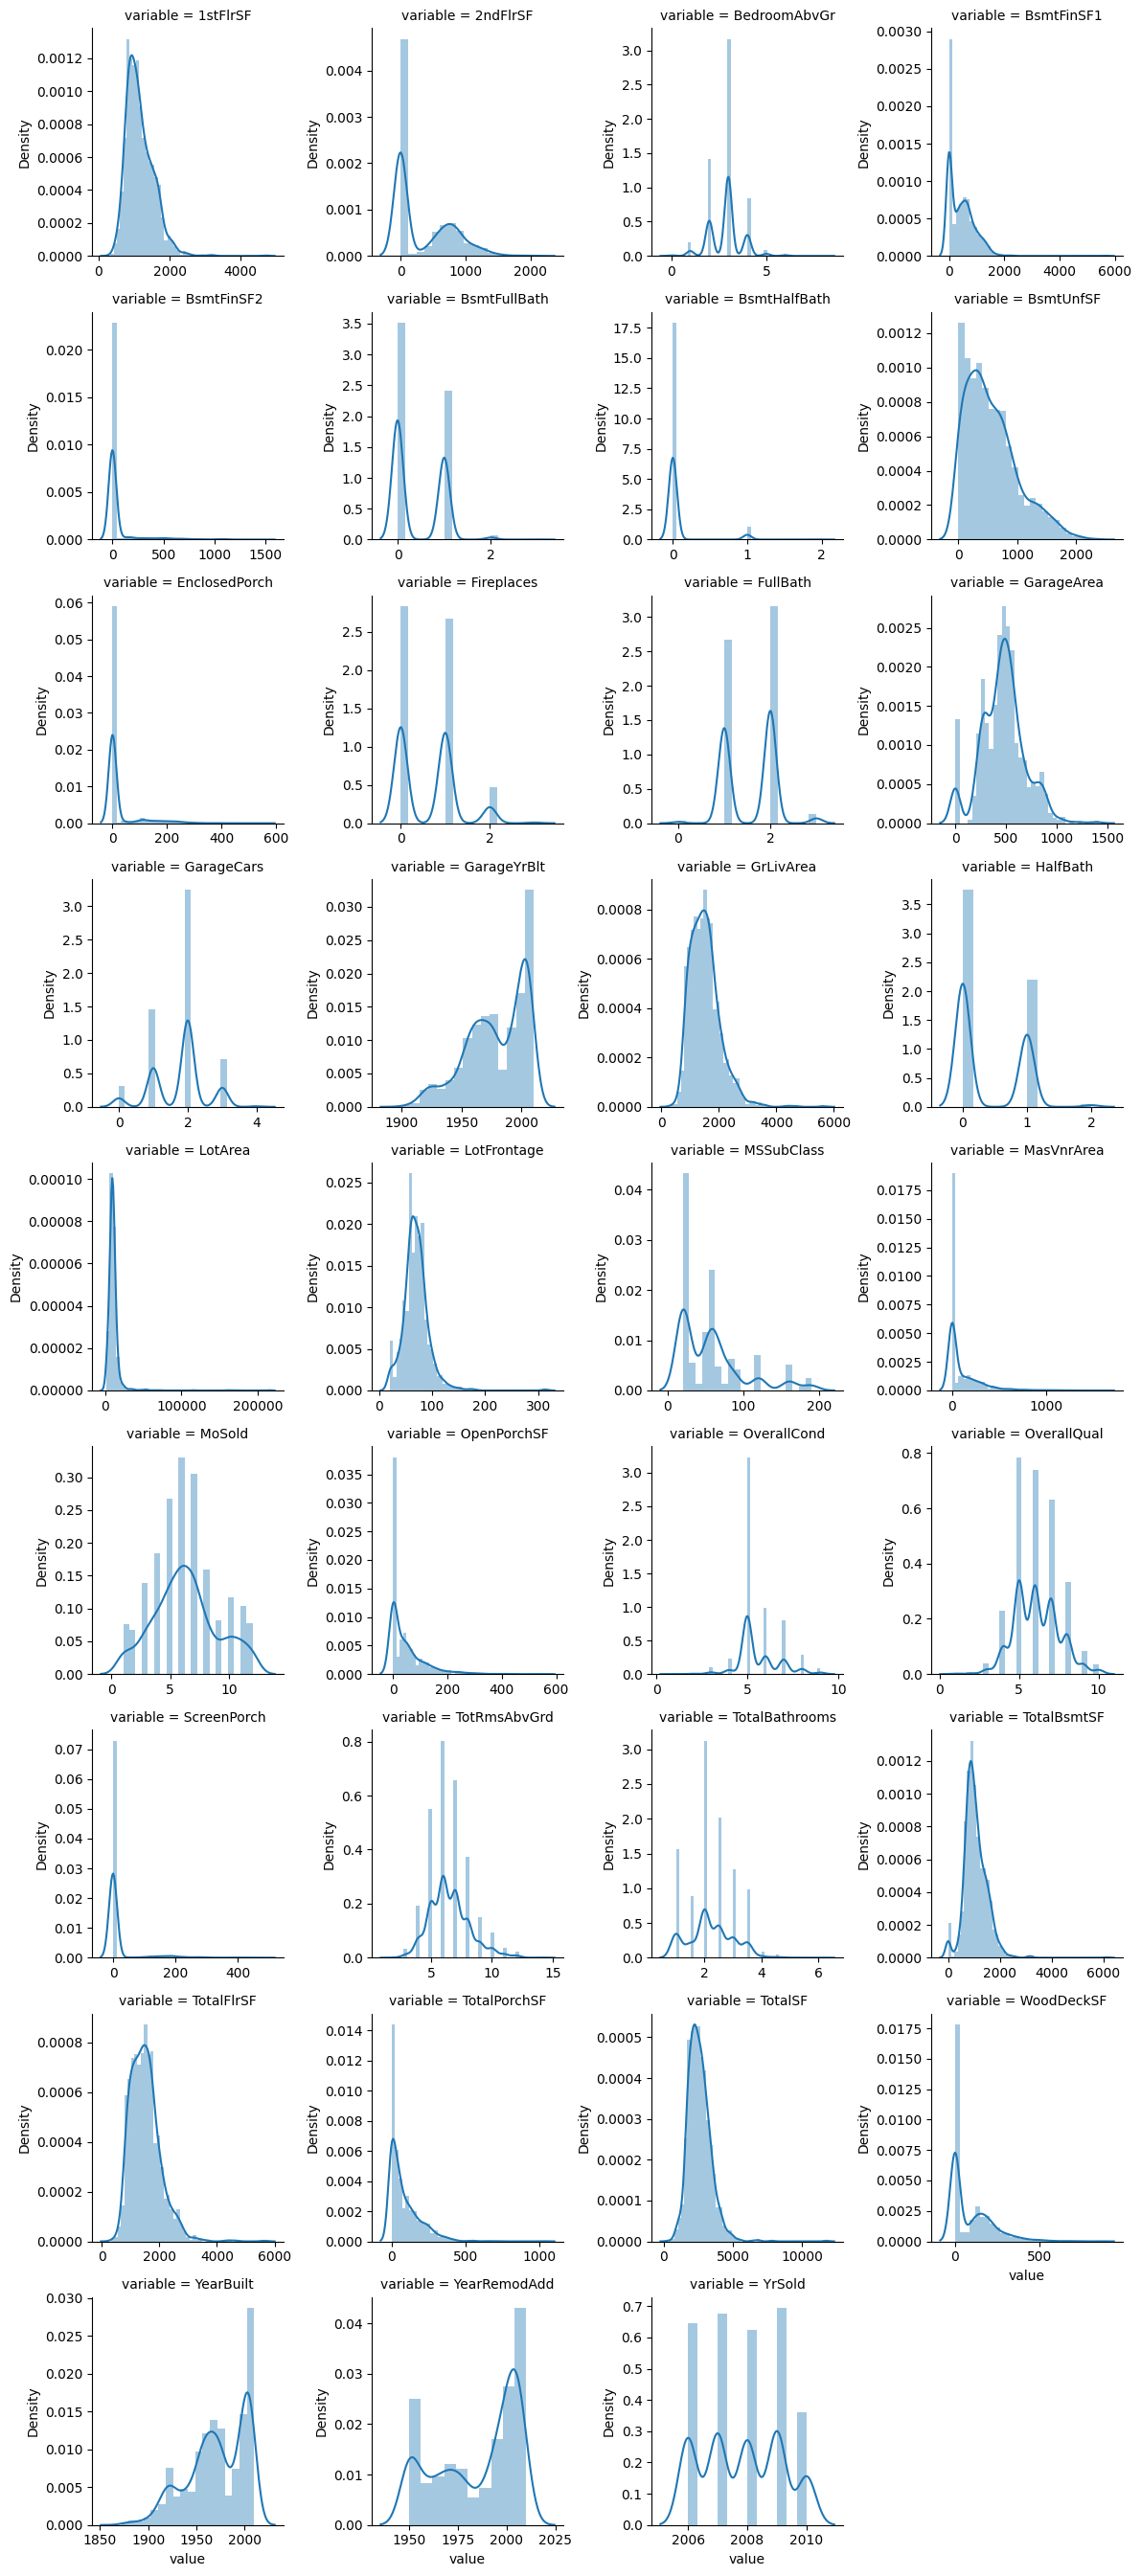

In [103]:
# Grid of distribution plots of all numerical features
f = pd.melt(train_data, value_vars=sorted(numerical_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

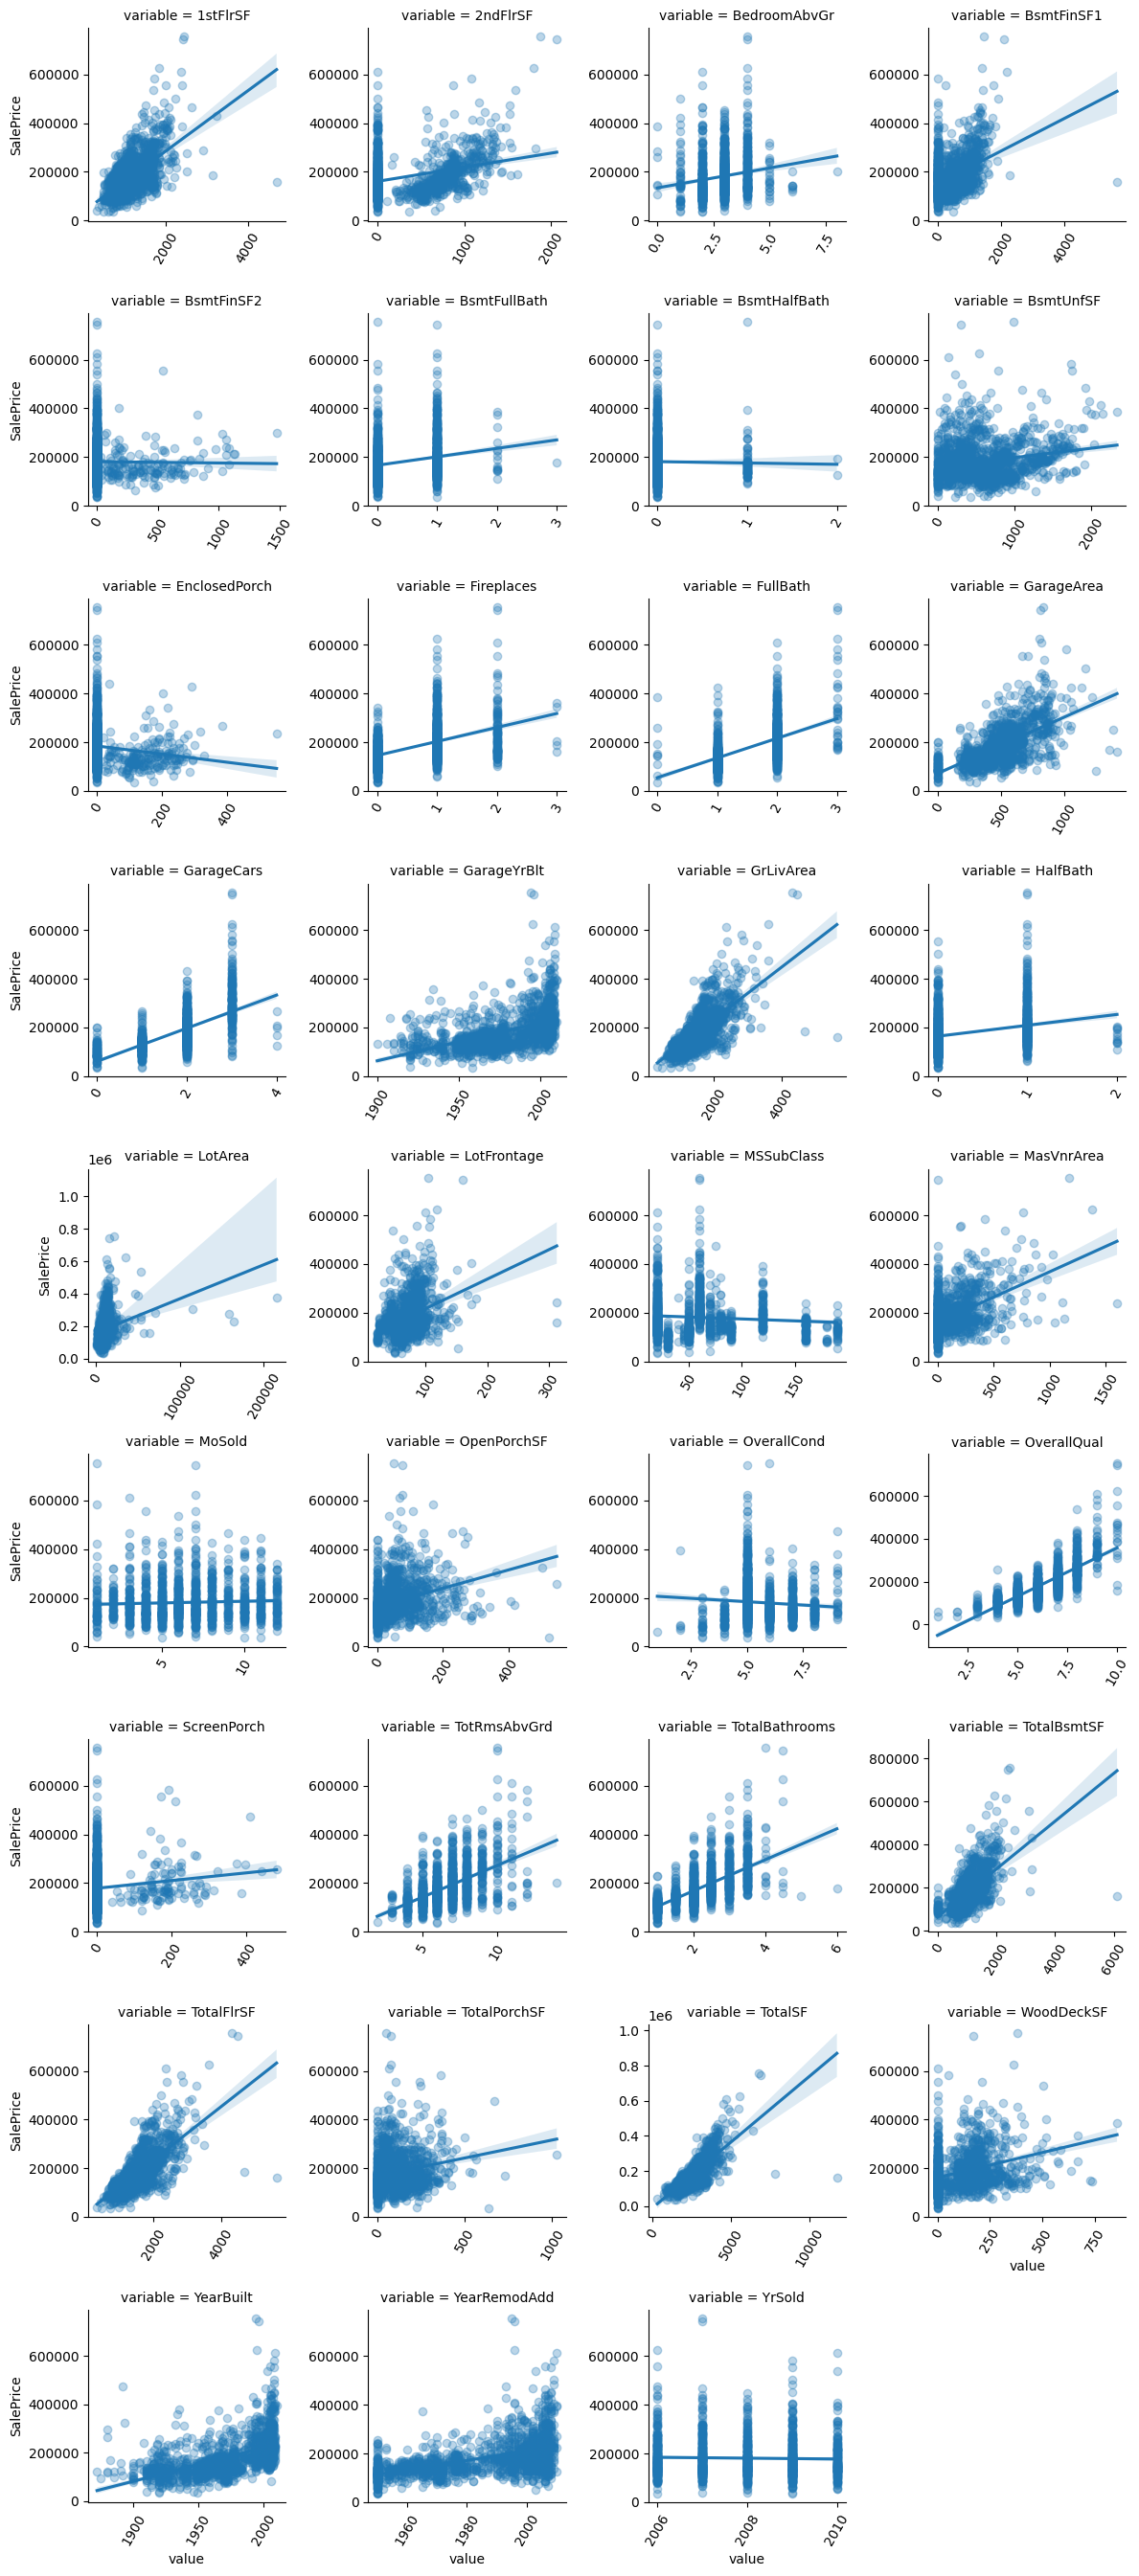

In [104]:
# Scatter plots of numerical features against SalePrice
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=sorted(numerical_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

['OverallQual', 'TotalSF', 'TotalFlrSF', 'GrLivArea', 'GarageCars', 'TotalBathrooms', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']


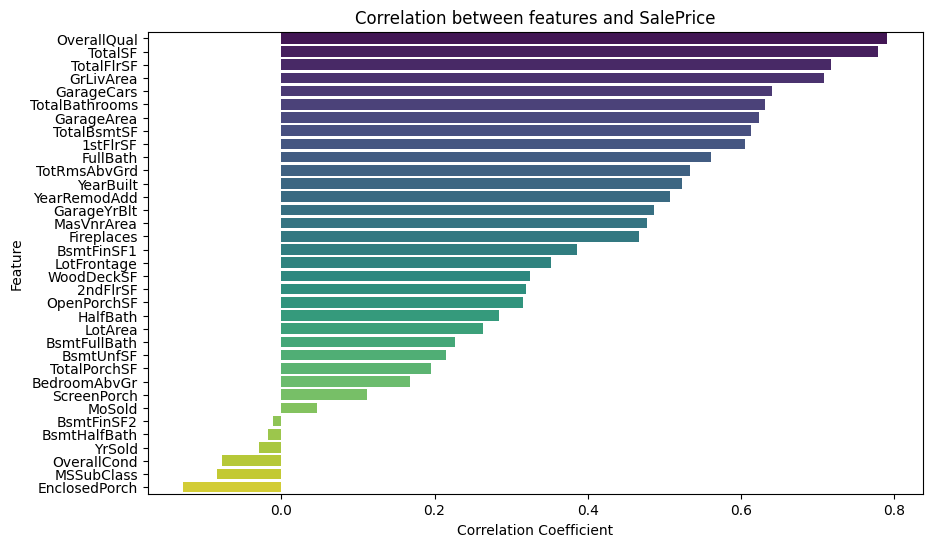

In [105]:

# Calculate correlation for each numerical feature with y
correlations = train_data[numerical_cols].corrwith(y_train['SalePrice'])

# Sort results by value
correlations = correlations.sort_values(ascending=False)
# print(correlations)

# Select features with correlation > 0.6
numerical_cols_relevant = correlations[abs(correlations) > 0.6].index.tolist()
numerical_cols_irrelevant = correlations[abs(correlations) <= 0.6].index.tolist()
print(numerical_cols_relevant)
# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette="viridis")
plt.title("Correlation between features and SalePrice")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

Silná korelácia medzi YearBuilt a GarageYrBlt: 0.83
Silná korelácia medzi TotalBsmtSF a 1stFlrSF: 0.82
Silná korelácia medzi TotalBsmtSF a TotalSF: 0.82
Silná korelácia medzi GrLivArea a TotRmsAbvGrd: 0.83
Silná korelácia medzi GrLivArea a TotalSF: 0.88
Silná korelácia medzi GrLivArea a TotalFlrSF: 1.00
Silná korelácia medzi TotRmsAbvGrd a TotalFlrSF: 0.82
Silná korelácia medzi GarageCars a GarageArea: 0.88
Silná korelácia medzi TotalSF a TotalFlrSF: 0.88


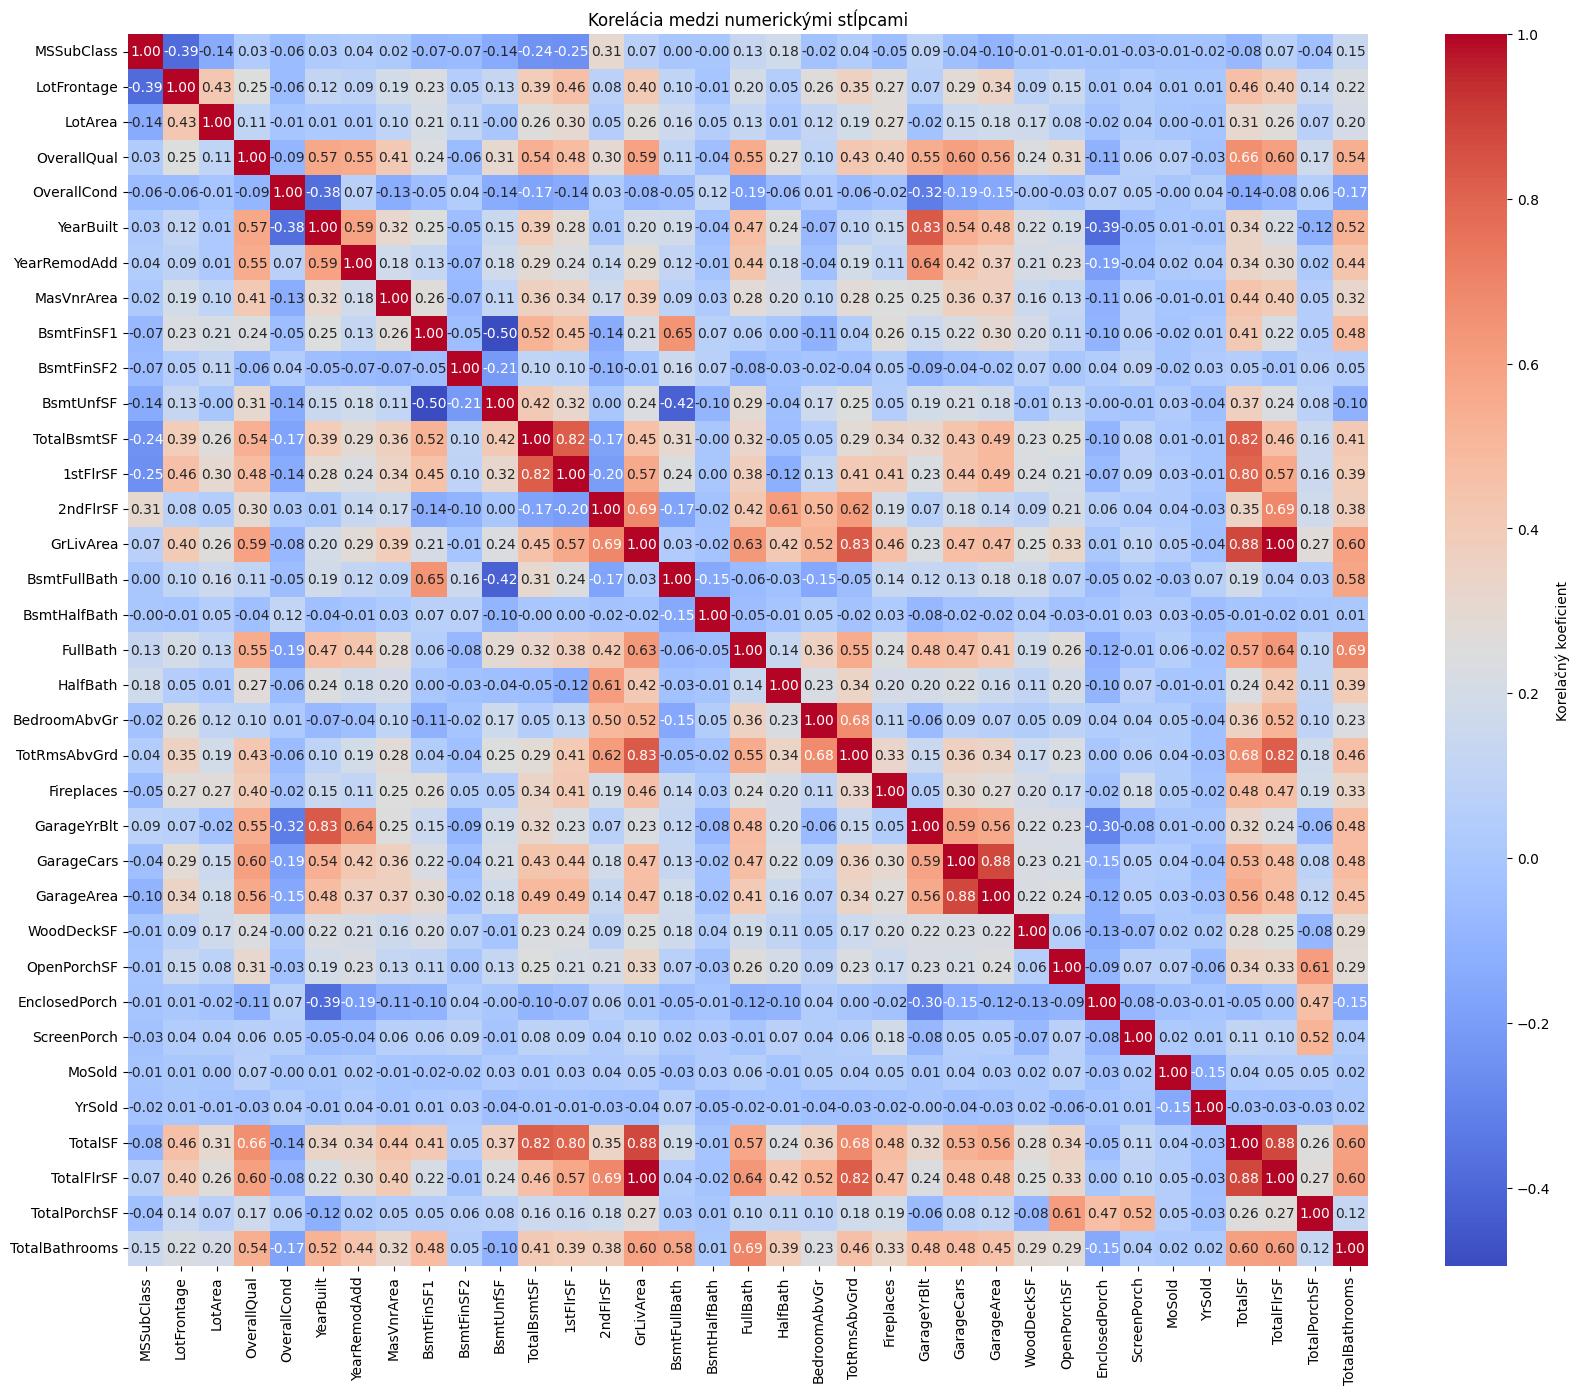

In [106]:

# Vypočítaj korelačnú maticu
correlation_matrix = train_data[numerical_cols].corr()

# Nastav prahovú hodnotu korelácie, napríklad 0.8 pre silné korelácie
threshold = 0.8

# Nahradíme všetky hodnoty nižšie než threshold hodnotou NaN
strong_correlation_matrix = correlation_matrix.applymap(lambda x: x if abs(x) >= threshold else np.nan)

# Nastavenie diagonály na NaN, aby sme odstránili korelácie medzi stĺpcami samými so sebou
np.fill_diagonal(strong_correlation_matrix.values, np.nan)

# Odstránime riadky a stĺpce, ktoré obsahujú iba NaN hodnoty
strong_correlation_matrix_clean = strong_correlation_matrix.dropna(how='all', axis=0)  # Odstrániť riadky s NaN
strong_correlation_matrix_clean = strong_correlation_matrix_clean.dropna(how='all', axis=1)  # Odstrániť stĺpce s NaN

# Zobrazenie výslednej matice so silnými koreláciami
#print(strong_correlation_matrix_clean)

# Vytvoríme cyklus, ktorý prejde cez korelácie a zabezpečí unikátne dvojice
for col1 in range(len(strong_correlation_matrix_clean.columns)):
    for col2 in range(col1+1, len(strong_correlation_matrix_clean.columns)):
        # Získame názvy stĺpcov
        col1_name = strong_correlation_matrix_clean.columns[col1]
        col2_name = strong_correlation_matrix_clean.columns[col2]
        
        # Skontroluj, či je korelácia väčšia než prahová hodnota
        correlation_value = strong_correlation_matrix_clean.loc[col2_name, col1_name]
        if abs(correlation_value) >= threshold and not np.isnan(correlation_value):
            # Vytlač dvojice stĺpcov a ich koreláciu
            print(f"Silná korelácia medzi {col1_name} a {col2_name}: {correlation_value:.2f}")
            
# Vykreslenie heatmapy korelačnej matice
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Korelačný koeficient'})
plt.title("Korelácia medzi numerickými stĺpcami")
plt.show()

## DROP UNRELEVANT COLUMNS

In [107]:
numerical_cols = [col for col in numerical_cols if col in numerical_cols_relevant]
train_data.drop(columns=numerical_cols_irrelevant, inplace=True)

## REPLACING OF MISSING VALUES WITH KNN

In [110]:
train_data = train_data.drop(columns=['SalePrice'])

# Initialize the KNN imputer (e.g., with 5 nearest neighbors)
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the imputer to the entire DataFrame (including numerical and encoded columns)
train_data_imputed = pd.DataFrame(knn_imputer.fit_transform(train_data), columns=train_data.columns)
#test_data_imputed = pd.DataFrame(knn_imputer.transform(test_data), columns=train_data.columns)

## STANDARDIZING 

In [112]:
# Common columns for standardization
cols_to_standardize = list(numerical_cols) + categorical_cols_for_OrdinalEncoding
#cols_to_standardize = list(set(numerical_cols + categorical_cols_for_OrdinalEncoding))

# Initialize the scaler
scaler = StandardScaler()

# Apply standardization only to numerical and ordinal columns
train_data_imputed[cols_to_standardize] = scaler.fit_transform(train_data_imputed[cols_to_standardize])
#test_data_imputed[cols_to_standardize] = scaler.transform(test_data_imputed[cols_to_standardize])

In [ ]:
train_data_imputed

## MUTUAL INFORMATION

In [113]:
# Vypočítať mutual information medzi vstupnými stĺpcami a cieľovou premennou
mi = mutual_info_classif(train_data_imputed, y_train)

# Vytvoríme DataFrame pre zobrazenie názvov stĺpcov a ich MI hodnoty
mi_df = pd.DataFrame({
    'Feature': train_data_imputed.columns,  # Názvy stĺpcov
    'Mutual Information': mi  # Hodnoty mutual information
})

# Zobraziť DataFrame
print(mi_df)

                   Feature  Mutual Information
0              OverallQual            1.107998
1              TotalBsmtSF            0.230702
2                 1stFlrSF            0.159767
3                GrLivArea            0.386593
4               GarageCars            1.775943
..                     ...                 ...
141  SaleCondition_AdjLand            0.002532
142   SaleCondition_Alloca            0.000000
143   SaleCondition_Family            0.000000
144   SaleCondition_Normal            2.130065
145  SaleCondition_Partial            0.012669

[146 rows x 2 columns]


In [114]:
# Nastavenie prahu, pod ktorým odstránime stĺpce (napr. 0.1)
threshold = 1

# Výber stĺpcov, ktoré majú MI väčšie ako stanovený prah
selected_features = mi_df[mi_df['Mutual Information'] > threshold]

# Zoznam vybraných stĺpcov
selected_columns = selected_features['Feature'].tolist()

print("Selected features based on MI: ", selected_columns)

Selected features based on MI:  ['OverallQual', 'GarageCars', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'CentralAir', 'PavedDrive', 'BsmtExposure', 'BsmtFinType2', 'Alley', 'LotShape', 'LandContour', 'Functional', 'MSZoning_RL', 'LotConfig_Inside', 'Condition1_Norm', 'RoofStyle_Gable', 'Electrical_SBrkr', 'GarageType_Attchd', 'Fence_NA', 'SaleType_WD', 'SaleCondition_Normal']


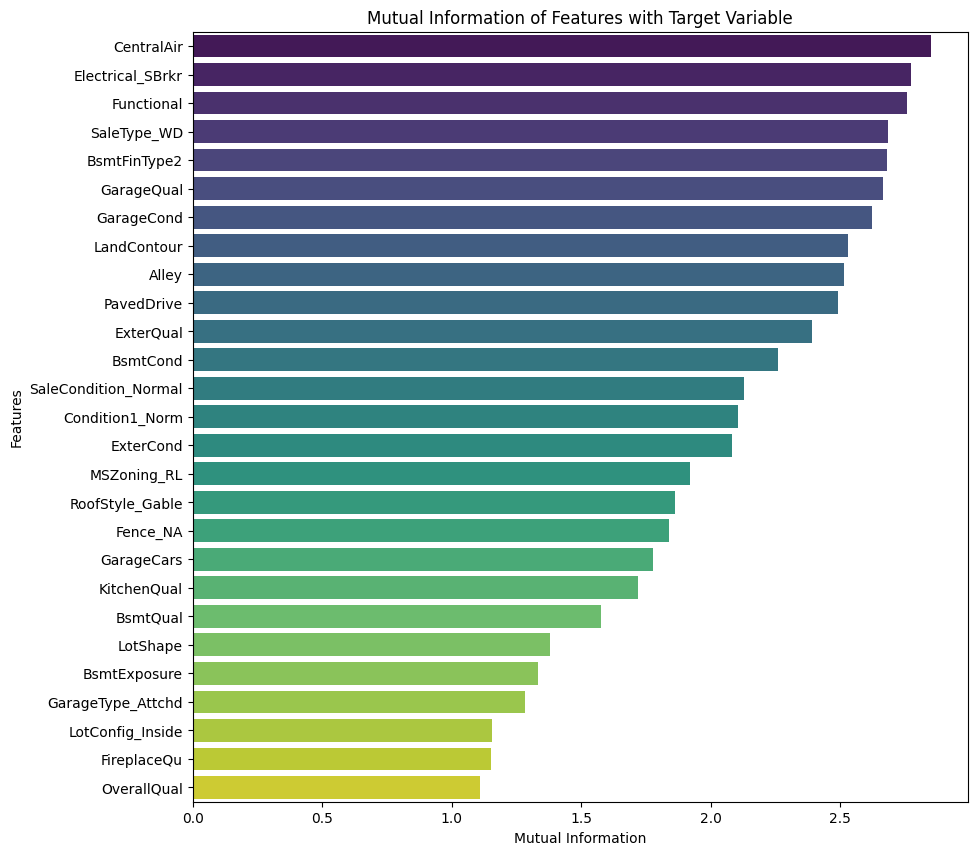

In [117]:
# Vytvoriť graf
plt.figure(figsize=(10, 10))
sns.barplot(x='Mutual Information', y='Feature', data=selected_features.sort_values(by='Mutual Information', ascending=False), palette='viridis')
plt.title('Mutual Information of Features with Target Variable')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

In [120]:
train_data_imputed = train_data_imputed[selected_columns]
#print(train_data_imputed)
# 4. Aplikácia PCA
pca = PCA()
pca_components = pca.fit_transform(train_data_imputed)

# 5. Variancia vysvetlená hlavnými komponentmi
explained_variance_ratio = pca.explained_variance_ratio_
#print("Explained variance ratio:", explained_variance_ratio)

# 6. Ponechanie len komponentov, ktoré vysvetľujú 95 % variancie
cumulative_variance = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_variance >= 0.95) + 1  # Prvých n komponentov
#print(f"Počet komponentov pre 95 % variancie: {num_components}")

# PCA s optimalizovaným počtom komponentov
pca_optimal = PCA(n_components=num_components)
reduced_data = pca_optimal.fit_transform(train_data_imputed)

# 7. Výsledok ako nový DataFrame
pca_columns = [f'PC{i+1}' for i in range(num_components)]
df_pca = pd.DataFrame(reduced_data, columns=pca_columns)

In [121]:
df_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.028422 -0.066501  0.641052 -1.051792 -0.378360  0.075310 -0.487717   
1    -0.635605 -0.072888 -1.020410  0.072703  0.149802 -0.069991 -1.107252   
2    -1.846841  0.454628  0.320254  0.204623 -0.397519 -0.343742  0.007584   
3    -1.598084 -0.236249 -0.099914  0.104204  0.022522 -0.283582  0.001130   
4    -2.767857  0.655688  0.418698  0.533256 -0.164086 -0.249947 -0.083503   
...        ...       ...       ...       ...       ...       ...       ...   
1455 -0.094125 -0.741483 -0.068317 -0.435572 -0.295878 -0.167183 -0.730785   
1456  0.068807 -0.980793 -0.811682  0.353487 -0.983338  2.033369  0.259197   
1457 -1.734619  0.235028 -0.281672 -1.955029 -0.303547 -0.576494  2.347358   
1458  0.759092 -0.822387 -1.286111 -0.318695 -0.489496  1.105075  0.162325   
1459  0.828714 -0.781201 -0.098347 -0.865351 -0.378091 -0.193901 -0.638958   

           PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0    -0.028823 -0.225994 -0.076700  1.036919 -0.438590  0.794022 -0.095802   
1    -0.001320 -1.029313 -0.194057 -0.814673  0.292154 -1.686915  0.446684   
2    -0.184561  0.619537 -0.248286 -0.033950 -0.067258 -0.233417 -0.437956   
3    -0.046195  1.025906 -0.306752 -1.263852  0.180327  0.510420  0.812019   
4    -0.364372  0.245584 -0.538731  0.100488 -0.190232 -0.900395  0.672726   
...        ...       ...       ...       ...       ...       ...       ...   
1455  0.100773 -0.193385  0.194175 -1.038252  0.391222  0.290965  0.578087   
1456 -0.251692 -0.306018  0.429675 -0.892334  0.333527  0.512410  0.623884   
1457  1.182613 -0.548001 -0.049633 -0.473643  0.565213  0.918908 -1.592864   
1458 -1.214758 -0.625418  0.640362  0.830564 -0.333972 -0.047215 -1.141810   
1459  0.085630 -0.000918  0.045239  0.658783 -0.219418  0.419992 -0.785066   

          PC15      PC16      PC17      PC18      PC19  
0    -0.351840 -0.092223 -0.109195 -0.500157 -0.015071  
1    -0.100209 -0.135265 -0.202571 -0.112824 -0.425923  
2    -0.202678  0.201450 -0.160278 -0.411542  0.238844  
3     1.821220 -0.265912  1.412841  0.586805  0.372444  
4     0.014121 -0.172847  0.385582 -0.384006 -0.038916  
...        ...       ...       ...       ...       ...  
1455 -0.146000 -0.053535 -0.689174 -0.318260 -0.011820  
1456 -0.168565 -0.280568 -0.673766 -0.188839 -0.170244  
1457 -0.923504  1.053785  1.573539 -0.535250 -0.289867  
1458  0.436109 -0.413097 -0.020666 -0.222414 -0.337101  
1459 -1.063432  0.962683  0.382786 -0.529187 -0.256811  

[1460 rows x 19 columns]

In [122]:
import xgboost as xgb
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Predpokladáme, že X a y sú definované
X = df_pca
y = y_train

# 1. Definícia funkcie na hodnotenie modelu
def objective(params):
    # Nastavenie K-fold cross-validácie
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_mse = []
    
    # XGBoost model s parametrami
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        fold_mse.append(mse)
    
    # Priemerný MSE pre všetky foldy
    mean_mse = np.mean(fold_mse)
    return {'loss': mean_mse, 'status': STATUS_OK}

# 2. Priestor pre hyperparametre
param_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.8, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0)
}

# 3. Optimalizácia
trials = Trials()
best_params = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=50,  # počet kombinácií
    trials=trials
)

# 4. Výsledky
print("Najlepšie parametre:", best_params)

100%|██████████| 50/50 [02:05<00:00,  2.51s/trial, best loss: 1579014259.6275592]
Najlepšie parametre: {'colsample_bytree': 0.9994852205384812, 'learning_rate': 0.03155497846210889, 'max_depth': 4.0, 'n_estimators': 180.0, 'subsample': 0.8917845399167753}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import space_eval

# 1. Výber výsledkov z Trials
results = pd.DataFrame(trials.results)  # Extrahujeme výsledky
results['loss'] = results['loss']  # Už obsahuje MSE ako stratu

# 2. Hyperparametre z Trials
params = pd.DataFrame([
    space_eval(param_space, {k: v[0] for k, v in trial['misc']['vals'].items()})  # Extrahujeme prvý prvok zo zoznamov
    for trial in trials.trials
])

# Spojenie výsledkov a parametrov
viz_data = pd.concat([params, results['loss']], axis=1)

# 3. Vizualizácia priebehu optimalizácie
plt.figure(figsize=(10, 6))
plt.plot(results['loss'], marker='o')
plt.xlabel('Iterácia')
plt.ylabel('MSE (strata)')
plt.title('Priebeh optimalizácie')
plt.show()

# 4. Distribúcia hyperparametrov a ich vplyv na stratu
for column in params.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=viz_data, x=column, y='loss')
    plt.xlabel(column)
    plt.ylabel('MSE (strata)')
    plt.title(f'Vzťah medzi {column} a stratou')
    plt.show()

# 5. Heatmap vzťahov medzi parametrami a stratou (voliteľné)
sns.pairplot(viz_data, diag_kind="kde")
plt.suptitle('Vzťahy medzi hyperparametrami a stratou', y=1.02)
plt.show()

In [123]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Najlepšie parametre z Hyperopt
best_params = {
    'n_estimators': int(best_params['n_estimators']),
    'max_depth': int(best_params['max_depth']),
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'random_state': 42
}

# Model s najlepšími parametrami
model = xgb.XGBRegressor(**best_params)

# K-fold cross-validácia
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Tréning modelu
    model.fit(X_train, y_train)
    
    # Predikcia na testovacom datasete
    y_pred = model.predict(X_test)
    
    # Výpočet MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Výstupy
print("MSE pre jednotlivé foldy:", mse_scores)
print("Priemerný MSE:", np.mean(mse_scores))
print("Štandardná odchýlka MSE:", np.std(mse_scores))

MSE pre jednotlivé foldy: [1908828227.4798634, 1553348578.893381, 1659352307.8959913, 1478899635.1277854, 1294642548.7407753]
Priemerný MSE: 1579014259.6275592
Štandardná odchýlka MSE: 203361938.6950359


In [ ]:
print(y_train.SalePrice.min())
print(y_train.SalePrice.mean())
print(y_train.SalePrice.max())

Here's some of the code you've written so far. Start by running it again.

# Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://storage.googleapis.com/kaggle-media/learn/images/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Data** tab near the top of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


# What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*